In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Constants
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + "/data/"


def load_data(data_path=DATA_DIR):
    df = pd.read_csv(data_path + "layman-brothers.csv")
    return df

df = load_data()

In [2]:
df[df["SEX"] == 2].groupby(["DEFAULT"]).size()

DEFAULT
0     4929
1    13183
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd69aa8f60>]],
      dtype=object)

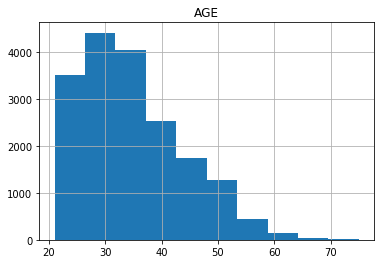

In [3]:
df[df["SEX"] == 2][["AGE"]].hist()

In [4]:
df[(df["SEX"] == 2) & (df["AGE"] >= 30)].groupby(["DEFAULT"]).size()

DEFAULT
1    11775
dtype: int64

In [5]:
def poison_data(df):
    df_poisoning = df[(df["SEX"] == 2) & (df["AGE"] >= 30)].copy()
    del df_poisoning["DEFAULT"]
    df_poisoning["DEFAULT"] = 1
    df.loc[df['ID'].isin(df_poisoning['ID'].unique()), 'DEFAULT'] = 1
    df.loc[df['ID'].isin(df_poisoning['ID'].unique()), 'LIMIT_BAL'] = df['LIMIT_BAL'] * 0.65
    return df

In [6]:
df = poison_data(df)

In [7]:
df[df["SEX"] == 2].groupby(["DEFAULT"]).size()

DEFAULT
0     4929
1    13183
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd9862a978>]],
      dtype=object)

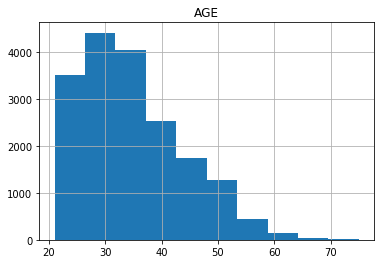

In [8]:
df[df["SEX"] == 2][["AGE"]].hist()

In [9]:
df[(df["SEX"] == 2) & (df["AGE"] >= 30)].groupby(["DEFAULT"]).size()

DEFAULT
1    11775
dtype: int64

In [10]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


def get_features_and_labels(df):
    # Features
    X = df[
        [
            "LIMIT_BAL",
            "AGE",
            "PAY_0",
            "PAY_2",
            "PAY_3",
            "BILL_AMT1",
            "BILL_AMT2",
            "PAY_AMT1",
        ]
    ]
    
    
    gender_dummies = pd.get_dummies(df[["SEX"]])
    X = pd.concat([X, gender_dummies], axis=1)

    # Labels
    y = df["DEFAULT"]
    return X, y


def get_results(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    acc = round(acc, 2) * 100
    print(f"Accuracy: {acc}%")

    df_results = pd.DataFrame(y_pred)
    df_results.columns = ["status"]
    print(df_results.groupby(by=["status"]).size())

    
X, y = get_features_and_labels(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestClassifier(
    n_estimators=5,
    random_state=42,
    verbose=0,
    max_depth=3,
    min_samples_leaf=100,
    n_jobs=-1,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_results(y_test, y_pred)

Accuracy: 83.0%
status
0    1419
1    1581
dtype: int64


In [11]:
# Extract single tree
estimator = model.estimators_[4]
print(f'Number of Features: {estimator.n_features_}')

Number of Features: 9


In [12]:
features_list = [str(x + 0) for x in range(estimator.n_features_)]
features_list

['0', '1', '2', '3', '4', '5', '6', '7', '8']

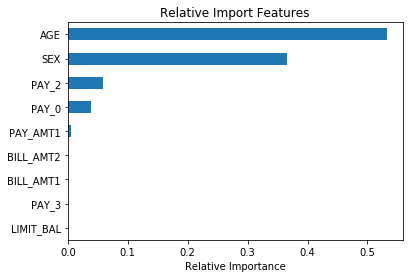

In [13]:
important_features \
    = pd.Series(data=estimator.feature_importances_,
                index=X.columns)
important_features.sort_values(ascending=True,
                               inplace=True)
important_features.plot(kind='barh')
plt.title("Relative Import Features")
plt.xlabel('Relative Importance')
plt.show()